# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat

# Imports

In [47]:
# TF and models, utils
# import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
import tensorflow.keras.metrics as tf_metrics
from tensorflow.keras.utils import to_categorical
import tensorflow_addons as tfa
import tensorflow_model_analysis as tfma

# image processing
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

# keras layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

# calbacks/checkpoints
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau

# regularization, initializers, optimizers, activations
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras import optimizers
from tensorflow.keras import activations

# file manipulation
import os
import shutil

# NumPy, pandas
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [3]:
# Run this cell to load the dataset

data_dir = ("~/Documents/coursera-basic-keras-classification/" +
            "GettingStarted/capstone_data")

train = loadmat(os.path.expanduser(data_dir) + '/train_32x32.mat')
test = loadmat(os.path.expanduser(data_dir) + '/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

First, see what the keys are in these dictionaries to see where the data are stored:

In [4]:
# get dictionary keys
print("Training dict keys: ", train.keys())
print("Test dict keys: ", test.keys())

Training dict keys:  dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
Test dict keys:  dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


Extract the data and place into the appropirately named variables:

In [5]:
# train and test targets
train_images = train["X"]
train_targets = train["y"]

test_images = test["X"]
test_targets = test["y"]

What is the shape of the data? This will become important as TensorFlow expects a certain shape for the model inpout.

In [6]:
print("Train data shape: {0}; train target shape{1}".format(train_images.shape, train_targets.shape))
print("Test data shape: {0}; test target shape{1}".format(test_images.shape, test_targets.shape))

Train data shape: (32, 32, 3, 73257); train target shape(73257, 1)
Test data shape: (32, 32, 3, 26032); test target shape(26032, 1)


Since the expected shape is either `(batch size, height, width, channels)` or `(bath size, channels, height, width)` we will need to move the last axis to the appropriate place, i.e., make it first. We'll move the last axis (the number of observations or the batch size) and have the result shape of our tain and test sets be `(batch size, height, width, channels)`.

In [7]:
# move axis (reshape) so that batch size is first and channels last
train_images = np.moveaxis(train_images, source=-1, destination=0)
test_images = np.moveaxis(test_images, source=-1, destination=0)

print("Reshaped train data shape: {}".format(train_images.shape))
print("Reshaped test data shape: {}".format(test_images.shape))

Reshaped train data shape: (73257, 32, 32, 3)
Reshaped test data shape: (26032, 32, 32, 3)


Out of curiousity, let's see what proportion the digits appear in the data (should follow Benford's law).

In [8]:
# train target frequencies
pd.Series(train_targets.ravel()).value_counts(normalize=True)

1     0.189211
2     0.144491
3     0.115989
4     0.101806
5     0.093943
6     0.078177
7     0.076375
8     0.068867
10    0.067543
9     0.063598
dtype: float64

In [9]:
# test target frequencies
pd.Series(test_targets.ravel()).value_counts(normalize=True)

1     0.195874
2     0.159381
3     0.110710
4     0.096919
5     0.091580
7     0.077558
6     0.075945
10    0.066994
8     0.063768
9     0.061271
dtype: float64

Even though it is printed above, let's double-check the target shape.

In [10]:
# TODO: create one-hot targets
# target shape
train_targets.shape

(73257, 1)

In [11]:
# to_categorical
train_targets_one_hot = to_categorical(train_targets)
test_targets_one_hot = to_categorical(test_targets)

In [12]:
print("One-hot train target shape: {}".format(train_targets_one_hot.shape))
print("One-hot test target shape: {}".format(test_targets_one_hot.shape))

One-hot train target shape: (73257, 11)
One-hot test target shape: (26032, 11)


Let's look at a random sample of images to see what the unnormalized digits look like:

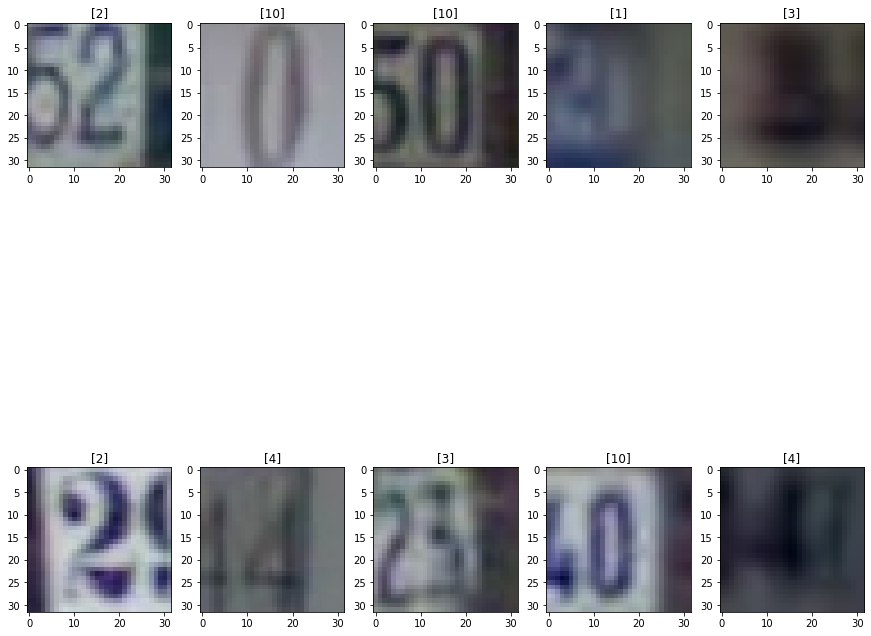

In [13]:
# random sample
tf.random.set_seed(1337)
rnd_idx = np.random.choice(np.arange(train_images.shape[0]), size=10, replace=False)

# plot 10 random training images and their labels
_, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 15));
axs = axs.flat

for idx in range(len(rnd_idx)):
  axs[idx].imshow(train_images[rnd_idx[idx], :, :, :]);
  axs[idx].set_title("{}".format(train_targets[rnd_idx[idx]]));

Now we convert the images to grayscale by taking the mean across the third axis, the channel dimension. We want to keep the dimension since this is part of input shape expected, so we use the keyword `keepdims=True`.

In [14]:
# convert images to grayscale;
# RGB color channel is third dimension
train_images_gray = np.mean(train_images, axis=-1, keepdims=True)
test_images_gray = np.mean(test_images, axis=-1, keepdims=True)

# check shapes
print("Grayscale train data shape: {}".format(train_images_gray.shape))
print("Grayscale test data shape: {}".format(test_images_gray.shape))

Grayscale train data shape: (73257, 32, 32, 1)
Grayscale test data shape: (26032, 32, 32, 1)


And now for a randm sample of grayscale images:

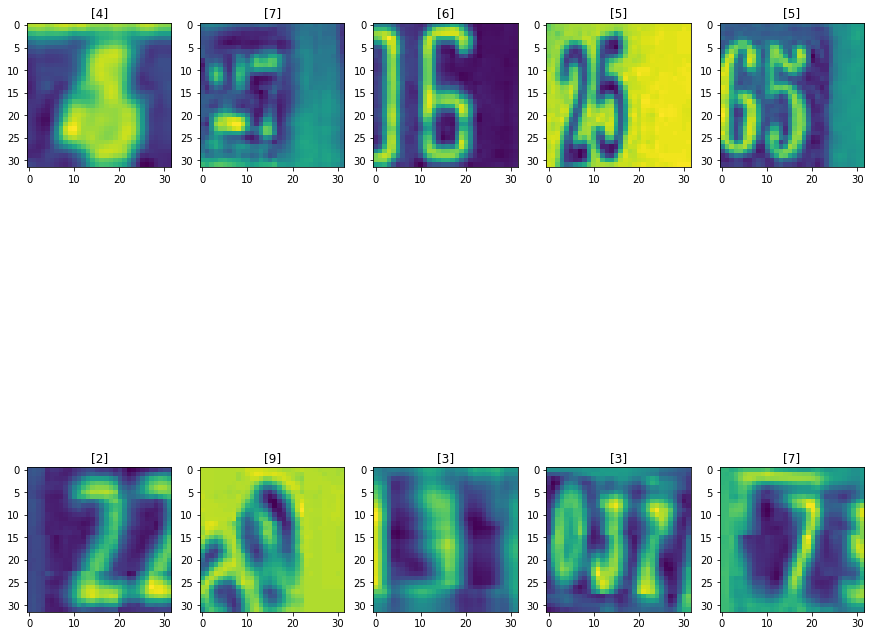

In [15]:
# random sample of grayscale images
tf.random.set_seed(1337)
rnd_idx = np.random.choice(np.arange(train_images_gray.shape[0]), size=10, replace=False)

# plot 10 random training images and their labels
_, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 15));
axs = axs.flat

# TODO: change default color map (viridis)
for idx in range(len(rnd_idx)):
  axs[idx].imshow(train_images_gray[rnd_idx[idx], :, :, :]);
  axs[idx].set_title("{}".format(train_targets[rnd_idx[idx]]))

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

This first model was just a stab in the dark. It did not work very well and essentially guessed the majority class. You can try it if you want, but it takes a long time to train and is not bery good.

In [16]:
# model is slow
# TODO: try regularizers.l1_l2(l1=..., l2=...)
def mlp_model_0(input_shape, l2_val):
  # build model
  # should input be a Dense layer instead?
  input_layer = Conv2D(filters=64,
                       kernel_size=(3, 3),
                       activation="relu",
                       padding="SAME",
                       input_shape=(input_shape),
                       data_format="channels_last",
                       kernel_initializer=tf.keras.initializers.HeUniform(),
                       bias_initializer="zeros",
                       kernel_regularizer=regularizers.l2(l2_val),
                       name="input_layer")
  conv_2 = Conv2D(filters=32,
                  kernel_size=(3, 3),
                  activation="relu",
                  padding="SAME",
                  kernel_initializer=tf.keras.initializers.HeUniform(),
                  bias_initializer="zeros",
                  kernel_regularizer=regularizers.l2(l2_val),
                  name="conv_2")
  flatten = Flatten(name="flatten")
  dense_1 = Dense(units=516, activation="relu",
                  kernel_regularizer=regularizers.l2(l2_val),
                  name="hidden_1")
  # output is from 1 to 11, so Dense(11,...) gives [1, 11)
  # TODO: create output layer compatible with one-hot encoding
  output = Dense(units=11, activation="softmax", name="output")
    
  model = Sequential()
  model.add(input_layer)
  model.add(conv_2)
  model.add(flatten)
  model.add(dense_1)
  model.add(output)
    
  # compile model
  model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy", 
                metrics=["accuracy"])
  return model

This second model works much better. By appying the techniques [linked in this post](https://towardsdatascience.com/designing-your-neural-networks-a5e4617027ed), this model gives a decent accuracy.

Short description of the rationales for some of the layers:

- 16 filters: relatively sane default
- `3 x 3` kernel size: relatively sane default
- ELU activation: model is not self-normalizing, i.e., no dropout, batch normalization layers, etc.
- LeCun weights: due to ELU activation function
- L2 regularization for tamping down extreme values
- 512 neurons: decent compromise for complexity and speed of fit


Architecture:
- 2D convolutional layer for image input
- Flattening layer: vecorization for input intp hidden layer
- First dense layer: identifying image edges
- Second dense layer: identifying combinations of edges
- Output layer: feature combinations

Optimization:
- use SGD for better convergence
- 0.9 momentum as a sane (?) default
- `nesterov=True` to account for the gradient (increases accuracy and speed)

In [17]:
# TODO: try regularizers.l1_l2(l1=..., l2=...)
def mlp_model_1(input_shape, l2_val, learning_rate, momentum):
  # build model
  input_layer = Conv2D(filters=16,
                       kernel_size=(3, 3),
                       activation="elu",
                       padding="SAME",
                       input_shape=(input_shape),
                       data_format="channels_last",
                       kernel_initializer=initializers.LecunNormal(),
                       bias_initializer="zeros",
                       kernel_regularizer=regularizers.l2(l2_val),
                       name="input_layer")
  flatten = Flatten(name="flatten")
  dense_1 = Dense(units=512,
                  activation="elu",
                  kernel_regularizer=regularizers.l2(l2_val),
                  name="hidden_1")
  dense_2 = Dense(units=512,
                  activation="elu",
                  kernel_regularizer=regularizers.l2(l2_val),
                  name="hidden_2")
  # output is from 1 to 11, so Dense(11,...) gives [1, 11)
  output = Dense(units=11, activation="softmax", name="output")
    
  model = Sequential()
  model.add(input_layer)
  model.add(flatten)
  model.add(dense_1)
  model.add(dense_2)
  model.add(output)
    
  # compile model
  # one-hot: need categorical accuracy
  model.compile(optimizer=optimizers.SGD(learning_rate=learning_rate,
                                         momentum=momentum,
                                         nesterov=True,),
                loss="categorical_crossentropy",
                metrics=[tf_metrics.CategoricalAccuracy(name="accuracy"),
                         tf_metrics.Precision(name="precision"),
                         tf_metrics.Recall(name="recall"),
                        ])
  return model

A quick compare and contrast of the model architectures:

In [18]:
mlp_classifier_0 = mlp_model_0(train_images_gray[0].shape, 1e-3)

mlp_classifier_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Conv2D)         (None, 32, 32, 64)        640       
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 32)        18464     
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
hidden_1 (Dense)             (None, 516)               16908804  
_________________________________________________________________
output (Dense)               (None, 11)                5687      
Total params: 16,933,595
Trainable params: 16,933,595
Non-trainable params: 0
_________________________________________________________________


In [19]:
mlp_classifier_1 = mlp_model_1(input_shape=train_images_gray[0].shape,
                               l2_val=1e-3,
                               learning_rate=1e-5,
                               momentum=0.9)

mlp_classifier_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Conv2D)         (None, 32, 32, 16)        160       
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
hidden_1 (Dense)             (None, 512)               8389120   
_________________________________________________________________
hidden_2 (Dense)             (None, 512)               262656    
_________________________________________________________________
output (Dense)               (None, 11)                5643      
Total params: 8,657,579
Trainable params: 8,657,579
Non-trainable params: 0
_________________________________________________________________


The model callbacks. This function:

- determines if the callback directories exist; if they do, overswrite them
- saves the weights every epoch
- saves the best weights, conditioned on the validation loss
- stops if the validation loss does not change within 0.1 for five (5) consecutive epochs
- Reduces the learning rate on if it platues for five (5) consecutive epochs

In [20]:
# callbacks
# TODO: rename with mlp_ prefix
def model_callbacks():
  # directories for epochs and best weights
  # check for exitence of directory; if it does, then delete;
  # prevents writing with previous epochs/weights
  # works in curent directory
  epoch_path = "epoch_checkpoints/checkpoint_{epoch:03d}"
  best_weight_path = "best_weights/checkpoint"
  
  if os.path.isdir("epoch_checkpoints/"):
    shutil.rmtree("epoch_checkpoints/")
  if os.path.isdir("best_weights/"):
    shutil.rmtree("best_weights/")

  # epochs
  epoch_checkpoint = ModelCheckpoint(filepath=epoch_path,
                                     save_freq="epoch",
                                     save_weights_only=True)
  # best weights  
  best_weight_checkpoint = ModelCheckpoint(filepath=best_weight_path,
                                           save_best_only=True,
                                           save_weights_only=True,
                                           monitor="val_loss")
  # early stopping
  early_stop = EarlyStopping(monitor="val_loss", patience=5,
                             mode="min", min_delta=0.1)
  # learning rate
  lr_plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5)

  return (epoch_checkpoint, best_weight_checkpoint, early_stop, lr_plateau)

In [21]:
%%script false --no-raise-error
# train the model


epoch_chk, weight_chk, early_stop, lr_reduce = model_callbacks()

mlp_history = mlp_classifier_0.fit(x=train_images_gray,
                                   y=train_targets_on,
                                   epochs=30,
                                   validation_split=0.2,
                                   batch_size=64,
                                   callbacks=[epoch_chk, weight_chk, early_stop, lr_reduce])

Now to run the model:

In [22]:
%%time
# train the model


epoch_chk, weight_chk, early_stop, lr_reduce = model_callbacks()

mlp_history = mlp_classifier_1.fit(x=train_images_gray,
                                   y=train_targets_one_hot,
                                   epochs=30,
                                   validation_split=0.2,
                                   batch_size=64,
                                   callbacks=[epoch_chk, weight_chk, early_stop, lr_reduce])

Epoch 1/30
916/916 [==============================] - 68s 73ms/step - loss: 12.8188 - accuracy: 0.1936 - precision: 0.2239 - recall: 0.0841 - val_loss: 3.5042 - val_accuracy: 0.3630 - val_precision: 0.5595 - val_recall: 0.1528
Epoch 2/30
916/916 [==============================] - 75s 81ms/step - loss: 3.3249 - accuracy: 0.4111 - precision: 0.6505 - recall: 0.2039 - val_loss: 3.1301 - val_accuracy: 0.4868 - val_precision: 0.7246 - val_recall: 0.2934
Epoch 3/30
916/916 [==============================] - 76s 83ms/step - loss: 2.9980 - accuracy: 0.5197 - precision: 0.7532 - recall: 0.3232 - val_loss: 2.8840 - val_accuracy: 0.5703 - val_precision: 0.7806 - val_recall: 0.3750
Epoch 4/30
916/916 [==============================] - 85s 93ms/step - loss: 2.7989 - accuracy: 0.5920 - precision: 0.8014 - recall: 0.4113 - val_loss: 2.8027 - val_accuracy: 0.5961 - val_precision: 0.7721 - val_recall: 0.4505
Epoch 5/30
916/916 [==============================] - 60s 65ms/step - loss: 2.6793 - accuracy: 

So the model seems to have done well. Let's plot the learning curves:

In [23]:
# learning curves
mlp_history_df = pd.DataFrame(mlp_history.history)
epochs = np.arange(mlp_history_df.shape[0])

mlp_history_df

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr
0,5.684639,0.259773,0.347821,0.104326,3.504152,0.363022,0.559470,0.152812,0.00001
1,3.233079,0.443563,0.686393,0.235509,3.130137,0.486759,0.724591,0.293407,0.00001
2,2.942264,0.542445,0.769778,0.348998,2.883981,0.570298,0.780620,0.374966,0.00001
3,2.772518,0.602423,0.807123,0.429639,2.802711,0.596096,0.772137,0.450519,0.00001
4,2.664237,0.641396,0.822540,0.483082,2.698118,0.638548,0.817937,0.477409,0.00001
5,2.582073,0.671854,0.835567,0.524409,2.675729,0.650287,0.817951,0.505050,0.00001
6,2.524706,0.689685,0.844148,0.554714,2.577864,0.681067,0.829465,0.553713,0.00001
7,2.474049,0.706032,0.853903,0.578841,2.536720,0.697038,0.839521,0.569479,0.00001
8,2.434216,0.719427,0.859368,0.597884,2.502496,0.705228,0.837930,0.584698,0.00001
9,2.400497,0.729392,0.864006,0.617166,2.489098,0.709664,0.841761,0.597598,0.00001


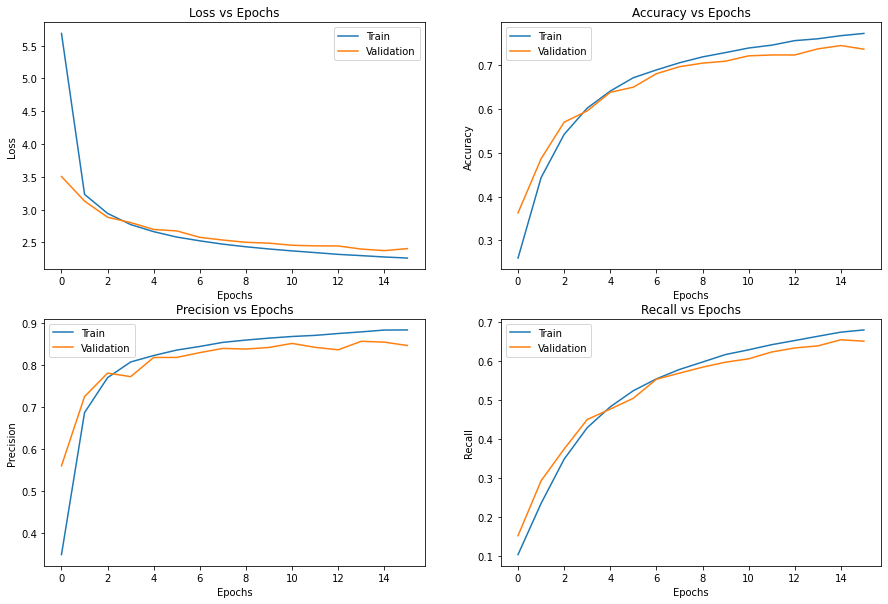

In [24]:
# plot learning curves
fig = plt.figure(figsize=(15,10))


# Loss plot
ax = fig.add_subplot(221)
ax.plot(epochs, mlp_history_df['loss'], label="Train")
ax.plot(epochs, mlp_history_df['val_loss'], label="Validation")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Epochs")
ax.legend()

# Accuracy plot
ax = fig.add_subplot(222)
ax.plot(epochs, mlp_history_df['accuracy'], label="Train")
ax.plot(epochs, mlp_history_df['val_accuracy'], label="Validation")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs Epochs")
ax.legend()

# precision plot
ax = fig.add_subplot(223)
ax.plot(epochs, mlp_history_df['precision'], label="Train")
ax.plot(epochs, mlp_history_df['val_precision'], label="Validation")
ax.set_xlabel("Epochs")
ax.set_ylabel("Precision")
ax.set_title("Precision vs Epochs")
ax.legend()

# recall plot
ax = fig.add_subplot(224)
ax.plot(epochs, mlp_history_df['recall'], label="Train")
ax.plot(epochs, mlp_history_df['val_recall'], label="Validation")
ax.set_xlabel("Epochs")
ax.set_ylabel("Recall")
ax.set_title("Recall vs Epochs")
ax.legend()

So this model does pretty well, and if ran for more epochs, could have reached an asymptote of some sort.

Time to evaluate the test performance:

In [25]:
test_targets_one_hot.shape

(26032, 11)

In [26]:
# test loss and accuracy

def test_performance(model, x, y):
  test_loss, _, test_precision, test_recall = model.evaluate(x, y, verbose=0)
  print("Test loss: {0:.3f}; test precision: {1:.3f}; test recall: {2:.3f}".format(test_loss,
                                                                                   test_precision,
                                                                                   test_recall))

test_performance(mlp_classifier_1, test_images_gray, test_targets_one_hot)

Test loss: 2.516; test precision: 0.815; test recall: 0.645


So this model performed aobu the same on thre training and test sets.

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

So this acitvation, initializers, optimizers, etc. are pretty much the same as the previous model. However, the architecture is different and because there is a `BatchNormalization` layer, we will not use L2 regularization.

Architecture:
- 2D convolutional layer for image input
- Flattening layer: vecorization for input intp hidden layer
- First dense layer: identifying image edges
- Scale the image edges
- Second dense layer: identifying combinations of edges
- Third dense layer: further combinations of features
- Output layer: feature combinations

In [27]:
def cnn_model_0(input_shape, learning_rate, momentum):
  # build model
  input_layer = Conv2D(filters=16,
                       kernel_size=(3, 3),
                       activation="elu",
                       padding="SAME",
                       input_shape=(input_shape),
                       data_format="channels_last",
                       kernel_initializer=initializers.LecunNormal(),
                       bias_initializer="zeros",
                       name="input_layer")
  flatten = Flatten(name="flatten")
  hidden_1 = Dense(units=128, activation="elu", name="hidden_1")
  norm = BatchNormalization(momentum=0.95, # 95% weight to previous mean
                            epsilon=0.005, # larger epsilon for stability (eps value)
                            axis = -1, # normalize over last (trailing) axis
                            # beta: zeros with 0.05 stndard dev
                            beta_initializer=initializers.RandomNormal(mean=0.0, stddev=0.05),
                            # gamma: vctor of 0.9
                            gamma_initializer=initializers.Constant(value=0.9),
                            name="norm")
  hidden_2 = Dense(units=64, activation="elu", name="hidden_2")
  hidden_3 = Dense(units=64, activation="elu", name="hidden_3")
  output = Dense(units=11, activation="softmax", name="output")

  model = Sequential()
  model.add(input_layer)
  #model.add(conv_2)
  model.add(flatten)
  model.add(hidden_1)
  model.add(norm)
  model.add(hidden_2)
  model.add(hidden_3)
  model.add(output)
  
  # compile model
# TODO: add TP, FP, TN, FN
  model.compile(optimizer=optimizers.SGD(learning_rate=learning_rate,
                                         momentum=momentum,
                                         nesterov=True,),
                loss="categorical_crossentropy",
                metrics=[tf_metrics.CategoricalAccuracy(name="accuracy"),
                         tf_metrics.Precision(name="precision"),
                         tf_metrics.Recall(name="recall"),
                         tf_metrics.AUC(name="auc"),
                         tf_metrics.AUC(name="pr_auc", curve="PR"),
                         # tf_metrics.TrueNegatives(name="true_neg"),
                         # tf_metrics.TruePositives(name="true_pos"),
                         # tf_metrics.FalseNegatives(name="false_neg"),
                         # tf_metrics.FalsePositives(name="false_pos")
                        ])
  return model
  

Note that this model as about one quarter fewer features than the previous one.

In [28]:
cnn_classifier_0 = cnn_model_0(input_shape=train_images_gray[0].shape,
                               learning_rate=1e-3,
                               momentum=0.9)

cnn_classifier_0.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Conv2D)         (None, 32, 32, 16)        160       
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
hidden_1 (Dense)             (None, 128)               2097280   
_________________________________________________________________
norm (BatchNormalization)    (None, 128)               512       
_________________________________________________________________
hidden_2 (Dense)             (None, 64)                8256      
_________________________________________________________________
hidden_3 (Dense)             (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 11)               

Callback are similar to that of the previous model:

In [29]:
# callbacks
def cnn_model_callbacks():
  # directories for epochs and best weights
  # check for exitence of directory; if it does, then delete;
  # prevents writing with previous epochs/weights
  # works in curent directory
  epoch_path = "cnn_epoch_checkpoints/checkpoint_{epoch:03d}"
  best_weight_path = "cnn_best_weights/checkpoint"
  
  if os.path.isdir("cnn_epoch_checkpoints/"):
    shutil.rmtree("cnn_epoch_checkpoints/")
  if os.path.isdir("cnn_best_weights/"):
    shutil.rmtree("cnn_best_weights/")

  # epochs
  epoch_checkpoint = ModelCheckpoint(filepath=epoch_path,
                                     save_freq="epoch",
                                     save_weights_only=True)
  # best weights  
  best_weight_checkpoint = ModelCheckpoint(filepath=best_weight_path,
                                           save_best_only=True,
                                           save_weights_only=True,
                                           monitor="val_loss")
  # early stopping
  early_stop = EarlyStopping(monitor="val_loss", patience=5,
                             mode="min", min_delta=0.1)
  # learning rate
  lr_plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5)

  return (epoch_checkpoint, best_weight_checkpoint, early_stop, lr_plateau)

Time to train the model:

In [30]:
%%time
# train the model


epoch_chk, weight_chk, early_stop, lr_reduce = cnn_model_callbacks()

cnn_history = cnn_classifier_0.fit(x=train_images_gray,
                                   y=train_targets_one_hot,
                                   epochs=30,
                                   validation_split=0.2,
                                   batch_size=64,
                                   callbacks=[epoch_chk, weight_chk, early_stop, lr_reduce])

Epoch 1/30
916/916 [==============================] - 21s 21ms/step - loss: 2.1967 - accuracy: 0.2369 - precision: 0.6816 - recall: 0.0132 - auc: 0.6793 - pr_auc: 0.2209 - val_loss: 2.0455 - val_accuracy: 0.2759 - val_precision: 0.7412 - val_recall: 0.0575 - val_auc: 0.7380 - val_pr_auc: 0.2938
Epoch 2/30
916/916 [==============================] - 19s 21ms/step - loss: 1.9709 - accuracy: 0.3097 - precision: 0.7416 - recall: 0.0773 - auc: 0.7627 - pr_auc: 0.3251 - val_loss: 2.2712 - val_accuracy: 0.2771 - val_precision: 0.8716 - val_recall: 0.0482 - val_auc: 0.6885 - val_pr_auc: 0.2755
Epoch 3/30
916/916 [==============================] - 20s 21ms/step - loss: 1.7147 - accuracy: 0.4189 - precision: 0.8366 - recall: 0.2075 - auc: 0.8263 - pr_auc: 0.4674 - val_loss: 1.2944 - val_accuracy: 0.5929 - val_precision: 0.8520 - val_recall: 0.3849 - val_auc: 0.9171 - val_pr_auc: 0.6661
Epoch 4/30
916/916 [==============================] - 19s 21ms/step - loss: 1.0386 - accuracy: 0.6754 - precisio

So this model takes about half the time of the previous one and appears to perform better in terms of loss and accuracy.

Let's plot the learning curves:

In [31]:
# learning curves
cnn_history_df = pd.DataFrame(cnn_history.history)
epochs = np.arange(cnn_history_df.shape[0])

cnn_history_df

,loss,accuracy,precision,recall,auc,pr_auc,val_loss,val_accuracy,val_precision,val_recall,val_auc,val_pr_auc,lr
0,2.093504,0.276819,0.790182,0.031038,0.723624,0.275805,2.045476,0.275867,0.741197,0.057467,0.737990,0.293754,0.001
1,1.928600,0.329545,0.788552,0.097551,0.773511,0.353614,2.271185,0.277095,0.871605,0.048185,0.688510,0.275481,0.001
2,1.571048,0.472519,0.842140,0.259432,0.861094,0.534816,1.294405,0.592888,0.851964,0.384930,0.917069,0.666119,0.001
3,0.944211,0.710776,0.880185,0.542769,0.953793,0.793458,0.903534,0.734439,0.850502,0.630562,0.959836,0.817575,0.001
4,0.740762,0.780428,0.887119,0.680283,0.969140,0.860343,0.908428,0.727546,0.827265,0.648171,0.954088,0.805415,0.001
5,0.654710,0.805102,0.893064,0.728760,0.974811,0.885361,0.733393,0.782282,0.869882,0.709050,0.968812,0.862451,0.001
6,0.600500,0.821176,0.894884,0.759014,0.978172,0.899327,0.780407,0.767336,0.847673,0.708709,0.965034,0.849956,0.001
7,0.563709,0.830543,0.897998,0.775446,0.980305,0.909090,0.686336,0.801938,0.866495,0.758804,0.972863,0.883431,0.001
8,0.534369,0.839161,0.903836,0.790342,0.982196,0.916986,0.605003,0.824051,0.884352,0.776072,0.976919,0.899385,0.001
9,0.509657,0.845883,0.906197,0.799488,0.983614,0.923202,0.597050,0.827054,0.891410,0.777641,0.978188,0.903489,0.001


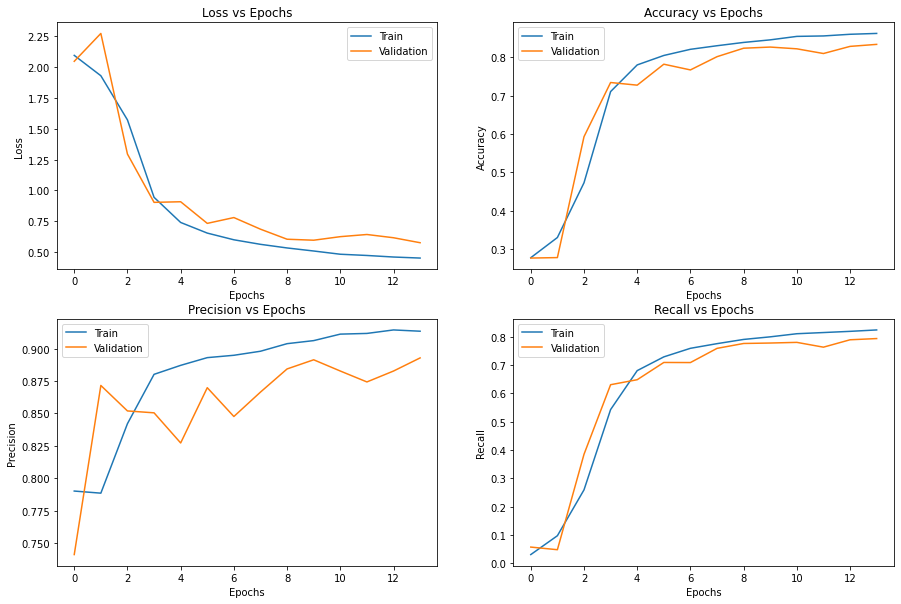

In [32]:
# plot learning curves
fig = plt.figure(figsize=(15,10))


# Loss plot
ax = fig.add_subplot(221)
ax.plot(epochs, cnn_history_df['loss'], label="Train")
ax.plot(epochs, cnn_history_df['val_loss'], label="Validation")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Epochs")
ax.legend()

# Accuracy plot
ax = fig.add_subplot(222)
ax.plot(epochs, cnn_history_df['accuracy'], label="Train")
ax.plot(epochs, cnn_history_df['val_accuracy'], label="Validation")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs Epochs")
ax.legend()

# precision plot
ax = fig.add_subplot(223)
ax.plot(epochs, cnn_history_df['precision'], label="Train")
ax.plot(epochs, cnn_history_df['val_precision'], label="Validation")
ax.set_xlabel("Epochs")
ax.set_ylabel("Precision")
ax.set_title("Precision vs Epochs")
ax.legend()

# recall plot
ax = fig.add_subplot(224)
ax.plot(epochs, cnn_history_df['recall'], label="Train")
ax.plot(epochs, cnn_history_df['val_recall'], label="Validation")
ax.set_xlabel("Epochs")
ax.set_ylabel("Recall")
ax.set_title("Recall vs Epochs")
ax.legend()

In [34]:
# test loss and accuracy

def test_performance(model, x, y):
  loss, _, prec, recall, auc, pr_auc = model.evaluate(x, y, verbose=0)
  print("Test performance")
  print("loss: {0:.3f}; precision: {1:.3f}; recall: {2:.3f}; AUC: {3:.3f}; PR AUC: {4:.3f}".format(loss, prec, recall, auc, pr_auc))

test_performance(cnn_classifier_0, test_images_gray, test_targets_one_hot)


Test performance
loss: 0.720; precision: 0.866; recall: 0.778; AUC: 0.973; PR AUC: 0.886


So while this model takes longer to minimize the loss, it performs more accurately.

Given the imblance of the classes, metrics such as precision/recall or sensitivity/specifity would likely give a better indication of model performance.

In [45]:
# multilabel confusion matrix

x = tfa.metrics.MultiLabelConfusionMatrix(num_classes=train_targets_one_hot.shape[1])
x.update_state(train_targets_one_hot, cnn_classifier_0.predict(train_images_gray))
x.result()

<tf.Tensor: shape=(11, 2, 2), dtype=float32, numpy=
array([[[7.3257e+04, 0.0000e+00],
        [0.0000e+00, 0.0000e+00]],

       [[5.9396e+04, 0.0000e+00],
        [1.3859e+04, 2.0000e+00]],

       [[6.2660e+04, 1.2000e+01],
        [1.0584e+04, 1.0000e+00]],

       [[6.4760e+04, 0.0000e+00],
        [8.4970e+03, 0.0000e+00]],

       [[6.5789e+04, 1.0000e+01],
        [7.4560e+03, 2.0000e+00]],

       [[6.6375e+04, 0.0000e+00],
        [6.8820e+03, 0.0000e+00]],

       [[6.7530e+04, 0.0000e+00],
        [5.7270e+03, 0.0000e+00]],

       [[6.7662e+04, 0.0000e+00],
        [5.5950e+03, 0.0000e+00]],

       [[6.8212e+04, 0.0000e+00],
        [5.0450e+03, 0.0000e+00]],

       [[6.8598e+04, 0.0000e+00],
        [4.6590e+03, 0.0000e+00]],

       [[6.8309e+04, 0.0000e+00],
        [4.9480e+03, 0.0000e+00]]], dtype=float32)>

In [52]:
# TODO: plot multilabel confusion matrix

y = tfma.metrics.MultiLabelConfusionMatrixPlot(num_thresholds=train_targets_one_hot.shape[1])


y

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

To get the best weights, we define a function that takes the model and saved weight directory as arguments:

In [35]:
# load weights
def get_best_weights(model, data_path):
    latest_checkpoint = tf.train.latest_checkpoint(data_path)
    model.load_weights(latest_checkpoint)
    return model

mlp_best_weights = get_best_weights(mlp_classifier_1, "best_weights/")
cnn_best_weights = get_best_weights(cnn_classifier_0, "cnn_best_weights/")

Now, we randomly select images and make predicitons based on our best weights:

In [36]:
# select images
tf.random.set_seed(42)
rnd_idx = np.random.choice(np.arange(test_images.shape[0]), size=5, replace=False)

In [37]:
# model predictions
mlp_predictions = mlp_best_weights.predict(test_images_gray[rnd_idx, :, :, :])
cnn_predictions = cnn_best_weights.predict(test_images_gray[rnd_idx, :, :, :])

Time to plot predictions:

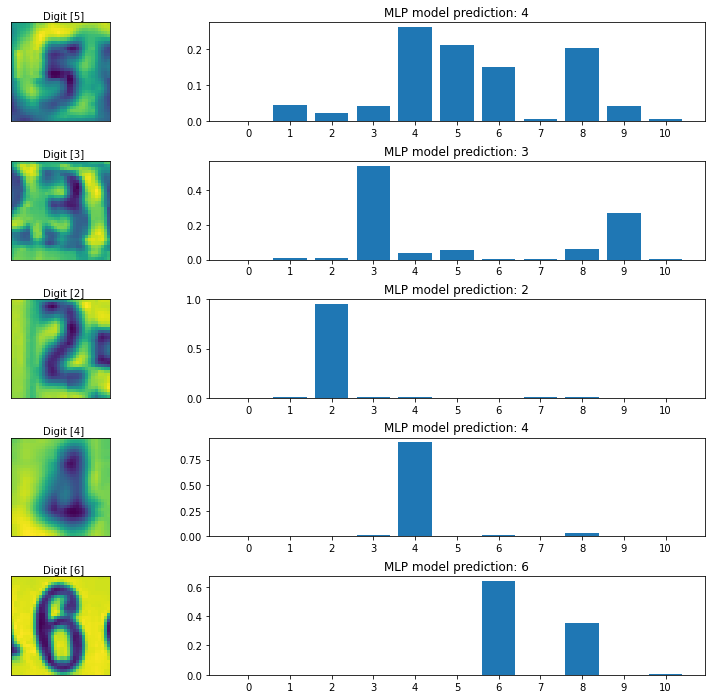

In [38]:
# MLP images, labels, and final prediction

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

rnd_test_imgs = test_images_gray[rnd_idx, :, :, :]
rnd_test_labels = test_targets[rnd_idx]

for i, (prediction, image, label) in enumerate(zip(mlp_predictions, rnd_test_imgs, rnd_test_labels)):
    axes[i, 0].imshow(image)
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title("MLP model prediction: {:0d}".format(np.argmax(prediction)))

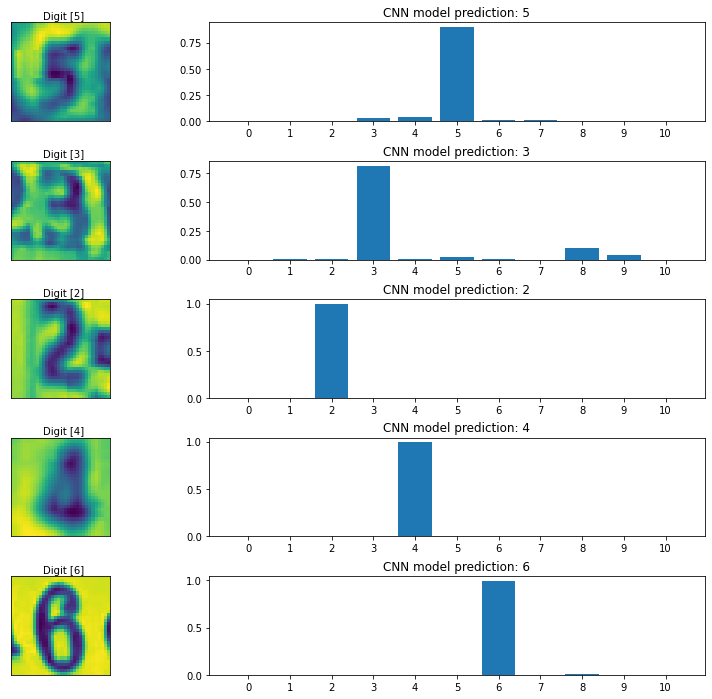

In [39]:
# CNN images, labels, and final prediction
fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

rnd_test_imgs = test_images_gray[rnd_idx, :, :, :]
rnd_test_labels = test_targets[rnd_idx]

for i, (prediction, image, label) in enumerate(zip(cnn_predictions, rnd_test_imgs, rnd_test_labels)):
    axes[i, 0].imshow(image)
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title("CNN model prediction: {:0d}".format(np.argmax(prediction)))

So we see with the second model, there is less uncertainty (confusion) in the predictions where digits may have multiple interpretations.